In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf

In [4]:
from investors import MomentumInvestor
from market_instance import new_market, make_investors
from stockmarket import Ask, Bid, Investor

In [5]:
class TradingEnvironment:
    """
    This class represents the RL environment of a single investor. It comprises of a
    portfolio of holdings - which includes a cash position - and the market with its
    players, in this case a bunch of momentum investors with limited reason...;-)
    """
    def __init__(self, config, holdings, market, tx_cost):
        self.config = config
        self.investor = self.create_investor(holdings)
        self.market = market
        self.other_investors = make_investors(config['num_investors'])
        self.tx_cost = tx_cost
        
    def create_investor(self, holdings):
        cash = holdings['cash']
        del(holdings['cash'])
        return Investor("WB", cash, holdings)        
        
    def let_others_trade(self):
        for _ in range(config['num_rounds_per_day']):
            for investor in self.other_investors:
                investor.act(self.market)
    
    def total_wealth(self):

        wealth = self.investor.cash
        for ticker in self.investor.portfolio:
            size = self.investor.portfolio[ticker]
            wealth += size * self.market.price_for(ticker)[1]
        return round(wealth,3)
    
    def normalized_holdings(self):
        values = {}
        values['cash'] = self.investor.cash
        for ticker in self.investor.portfolio:
            values[ticker] = holdings[ticker] * self.market.price_for(ticker)[1]
        w = environment.total_wealth()
        return np.array([v/w for _,v in sorted(values.items())])
    
    def act(self, new_weights):
        """
        This constitutes a trading day. We act, and then the market moves on.
        """
        market.open()

        orders = self.create_orders(new_weights)
        for order in orders:
            market.execute(order)

            total_tx_volume = np.sum(
                [order.amount * order.price for order in orders])
        
        fee = total_tx_volume * self.tx_cost
        self.investor.cash = round(self.investor.cash - fee, 3)
        
        self.let_others_trade()
        self.market.close()
        
        return self.state_rep()
    
    def state_rep(self):
        return "To be implemented"
    
    def create_orders (self, new_weights):
        """
        Create an order book from the target portfolio weights
        new_weights: list of normalized weights of the holdings
        sorted by the holdings' ticker names, cash last
        """
        cur_weights = self.normalized_holdings()
        vols = ((new_weights - cur_weights) * self.total_wealth())[:-1]
        holdings = self.investor.portfolio
        tickers = sorted(holdings)
        prices = np.array([self.market.price_for(t) for t in tickers])

        # identify the correct prices for bid and ask transactions
        bid_asks = [p[(v<0).astype(int)] for v,p in zip(vols, prices)]

        orders = []
        for v, ba, t in zip(vols, bid_asks, tickers):
            amt = np.abs((v/ba).astype(int))
            B_or_A = Bid if v>0 else Ask
            if v != 0:
                orders.append(B_or_A(price=ba, amount=amt, 
                                  ticker=t, other_party=self.investor))
        return orders

### Configuration for the synthetic market

In [6]:
config = {
    'num_investors': 10,
    'num_rounds_per_day': 3
}

### Our own portfolio

In [7]:
holdings = {
    'cash': 100000.00, 
    'TSLA': 300, 
    'AAPL': 200, 
    'MSFT': 400}

### Create the RL Environment

In [8]:
market = new_market()
environment = TradingEnvironment(config, holdings, market, 0.002)

## The market in action

In [9]:
for _ in range(360):
    market.open()
    daily = environment.let_others_trade()
    market.close()

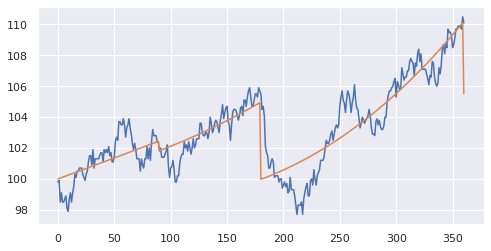

In [10]:
def plot(ticker):
    sns.set(rc={'figure.figsize':(8.0,4.0)})
    h = market.history_for(ticker)
    s = market.stocks[ticker]
    p_open, p_close, p_high, p_low = np.transpose(h)
    t = np.array(range(len(p_open)))
    sns.lineplot(t, p_open);
    sns.lineplot(t, [s.psi(tt) for tt in t]);
plot('AAPL')

## Perform an Action = Re-Balance

In [11]:
target_weights = np.array([.1, .3, .4, .2])

In [12]:
investor = environment.investor
print(investor, environment.total_wealth())
environment.act(target_weights)
print(investor, environment.total_wealth())

WB (cash: 100000.0, {'TSLA': 300, 'AAPL': 200, 'MSFT': 400}) 251308.7
WB (cash: 50186.974, {'TSLA': 698, 'AAPL': 231, 'MSFT': 349}) 251673.266


In [13]:
# slightly off-target because of integer stock counts and the trading costs.
environment.normalized_holdings()

array([0.0993121 , 0.29599509, 0.40527961, 0.19941321])